In [1]:
import os
from datetime import datetime

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tqdm import tqdm_notebook as tqdm

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10604584997646925441
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6709723791
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16587487645879622866
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [3]:
HEIGHT = 28 # Height of the image
WIDTH = 28 # Width of the image
CHANNELS = 1 # Number of channels for an image

Z_DIM = 100 # Dimensions of noise vector z
BATCH_SIZE = 64 # Batch size for training

G_FILTERS = 32 # Number of filters in the final deconv layer for Generator
D_FILTERS = 32 # Number of filters in the first conv layer for Discriminator

WEIGHT_CLIP = 0.01
D_LEARNING_RATE = 2e-5
G_LEARNING_RATE = 2e-5
N_EPOCHS = 100000
BETA1 = 0.5
G_ITERS = 1
D_ITERS = 5
G_USE_BATCHNORM = True
D_USE_BATCHNORM = True

TIME_FORMAT = datetime.now().strftime('%h-%d-%Y-%Hh%Mm%Ss')

g_filters = [128, 64, 32]
g_kernels = [4, 4, 4]
g_strides = [2, 2, 1]

d_filters = [64, 128]
d_kernels = [4, 4, 4]
d_strides = [2, 2, 2]
RUN_NAME = f"d_lr_{D_LEARNING_RATE}_g_lr{G_LEARNING_RATE}_{BETA1}_{G_ITERS}_{N_EPOCHS}_dbn_{D_USE_BATCHNORM}_gbn_{G_USE_BATCHNORM}_{g_filters[0]}_{g_kernels[0]}_{g_strides[0]}_{TIME_FORMAT}"

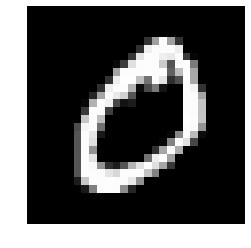

In [4]:
image_dir = 'C:\\Users\\Jonathan\\Documents\\development\\datasets\\images\\mnist\\training'
image_list = []

for directory in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
    for root, d, files in os.walk(os.path.join(image_dir, directory)):
        for file in files:
            if file.endswith('.png'):
                image_list.append(os.path.join(directory, file))

plt.imshow(cv2.imread(os.path.join(image_dir, image_list[0])))
plt.axis('off')
plt.show()

In [5]:
image_list = image_list[:59904]
len(image_list) / BATCH_SIZE

936.0

In [6]:
def make_grid(images, rows=8, cols=8):
    grid = np.zeros([images.shape[1] * rows, images.shape[2] * cols, images.shape[3]])
    
    if rows * cols > images.shape[0]:
        return
    
    i = 0
    for y in range(0, grid.shape[0], images.shape[1]):
        for x in range(0, grid.shape[1], images.shape[2]):
            grid[y:y+images.shape[1], x:x + images.shape[2]] = images[i]
            i += 1
    return grid

def plot_images(images, rows=8, cols=8):
    grid = make_grid(images, rows, cols)
    plt.figure(figsize=(12, 12))
    plt.imshow(np.squeeze(grid), cmap='gray')
    plt.axis('off')
    plt.show()

In [7]:
def inverse_transform(image):
    return ((image + 1.) / 2.).clip(0, 1)

def transform(image):
    return ((image * 2. - 1.)).clip(-1, 1)

def conv_out_size_same(size, stride):
    return int(math.ceil(float(size) / float(stride)))

def generator(z, filters=[256, 128, 64], kernels=[5, 5, 5], 
              strides=[2, 2, 2], training=True, reuse=False, use_batchnorm=True):
    s_h, s_w = HEIGHT, WIDTH
    for i in range(len(filters)):
        s_h, s_w = conv_out_size_same(s_h, strides[i]), conv_out_size_same(s_w, strides[i])
    
    with tf.variable_scope("generator", reuse=reuse) as scope:
        z = tf.layers.dense(z, 1024, name='g_fc0')
        z = tf.nn.relu(z)
        z = tf.layers.dense(z, filters[0] * s_h * s_w, use_bias=False, name='g_h0')
        z = tf.reshape(z, [-1, s_h, s_w, filters[0]])
        z = tf.layers.batch_normalization(z, training=training, name='g_bn0')
        z = tf.nn.relu(z)

        for i in range(len(filters) - 1):
            z = tf.layers.conv2d_transpose(z, filters[i + 1], kernel_size=kernels[i], strides=strides[i], padding='SAME',
                                            kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev=0.02),
                                            name=f'g_h{i + 1}')
            if use_batchnorm:
                z = tf.layers.batch_normalization(z, training=training, name=f'g_bn{i + 1}')
            z = tf.nn.relu(z)
        
        z = tf.layers.conv2d_transpose(z, CHANNELS, kernel_size=kernels[len(filters) - 1], 
                                       strides=strides[len(filters) - 1], padding='SAME',
                                        kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev=0.02),
                                        name=f'g_h{len(filters)}')
        
#         z = tf.layers.conv2d(z, CHANNELS, kernel_size=3, 
#                              strides=1, padding='SAME', 
#                              kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev=0.02), 
#                              name=f'g_h{len(filters)}')
        return tf.nn.tanh(z)

def discriminator(x, filters=[64, 128, 256], kernels=[5, 5, 5], 
                  strides=[2, 2, 2], training=True, reuse=False, use_batchnorm=True):
    s_h, s_w = HEIGHT, WIDTH
    for i in range(len(filters)):
        s_h, s_w = conv_out_size_same(s_h, strides[i]), conv_out_size_same(s_w, strides[i])

    with tf.variable_scope("discriminator", reuse=reuse) as scope:
        for i in range(len(filters)):
            x = tf.layers.conv2d(x, filters[i], kernel_size=kernels[i], strides=strides[i], padding='SAME',
                                   kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev=0.02),
                                   name=f'd_h{i}')
            if use_batchnorm:
                x = tf.layers.batch_normalization(x, training=training, name=f'd_bn{i}')

            x = tf.nn.leaky_relu(x, alpha=0.2)

        x = tf.layers.dense(tf.reshape(x, [BATCH_SIZE, filters[-1] * s_h * s_w]), 1024, name=f'd_h{len(filters)}')
        if use_batchnorm:
            x = tf.layers.batch_normalization(x, training=training, name=f'd_bn{len(filters)}')
        x = tf.nn.leaky_relu(x, alpha=0.2)
        x = tf.layers.dense(x, 1, name=f'd_h{len(filters) + 1}')
        
        return x

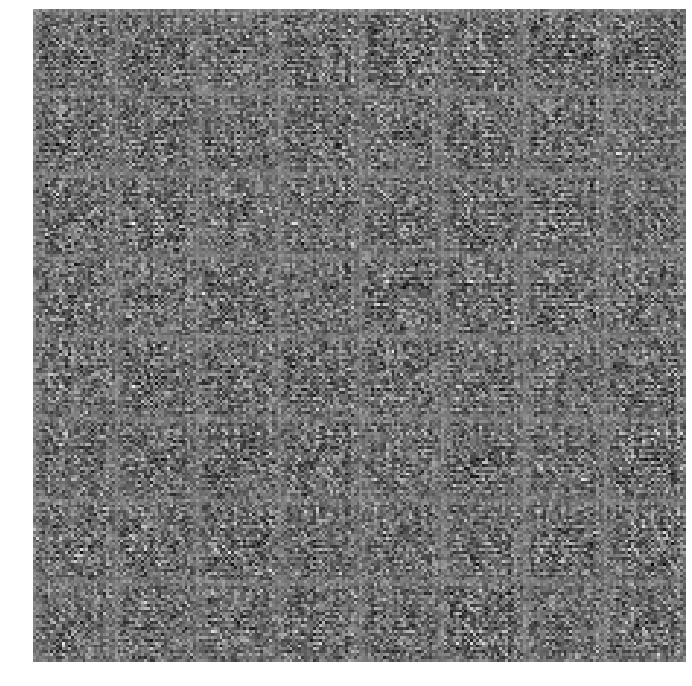

[Epoch 0/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


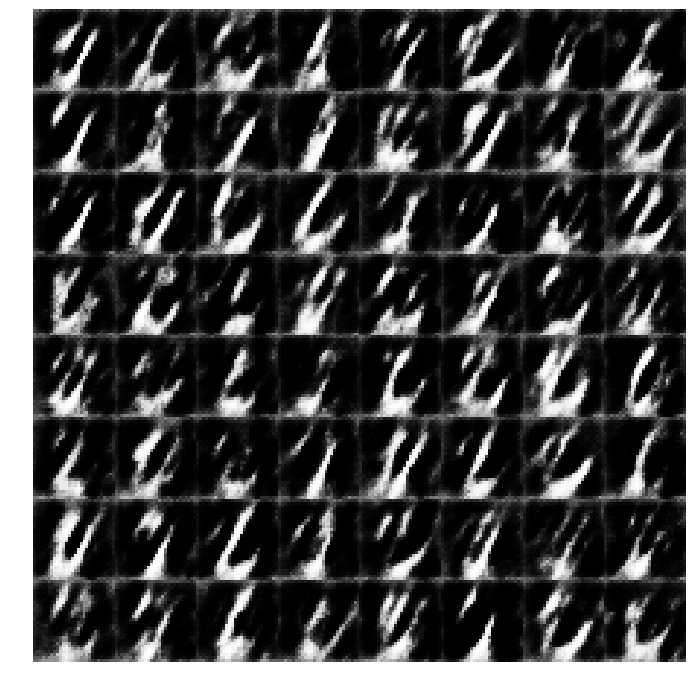

[Epoch 5/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


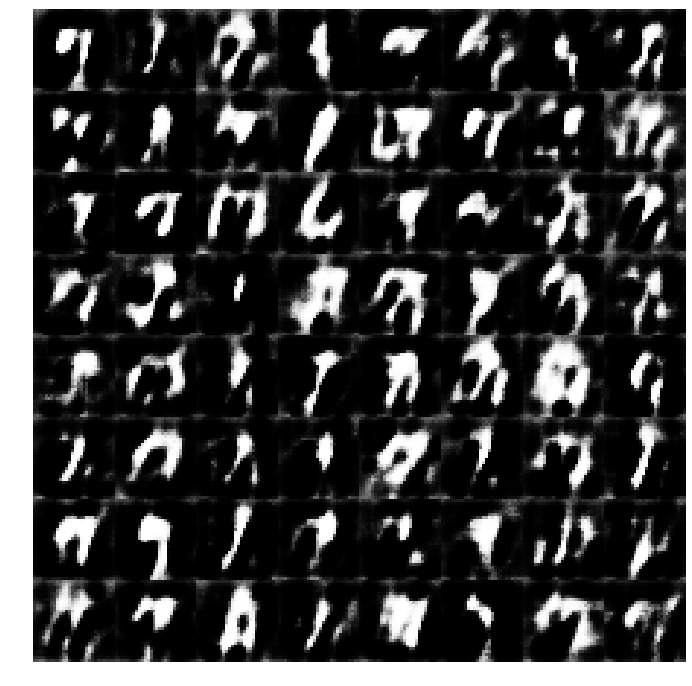

[Epoch 10/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


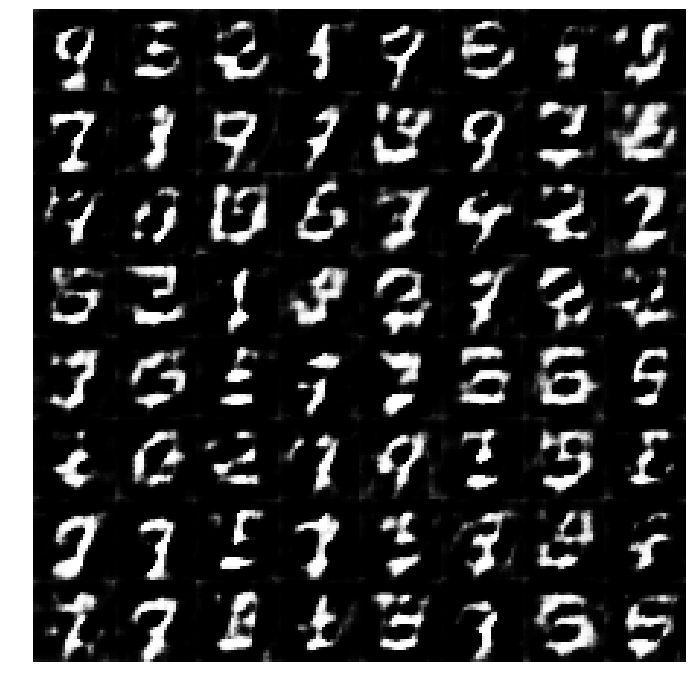

[Epoch 15/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


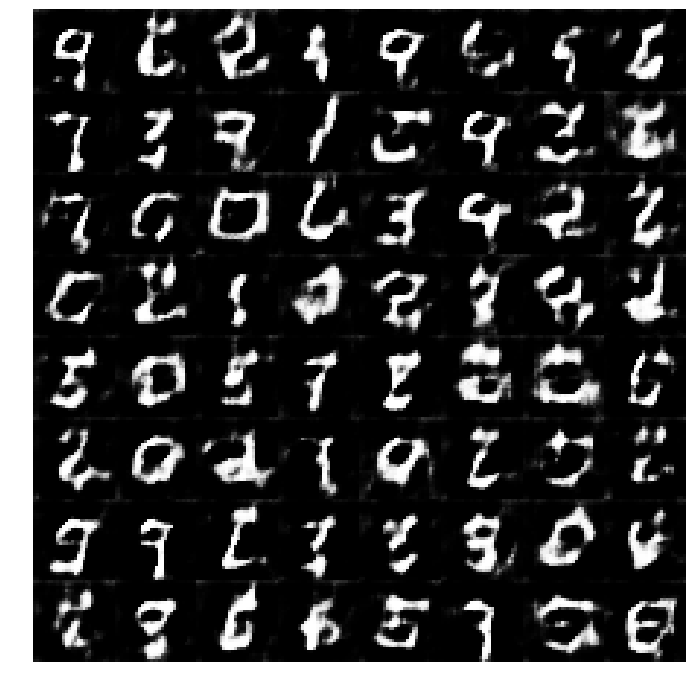

[Epoch 20/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


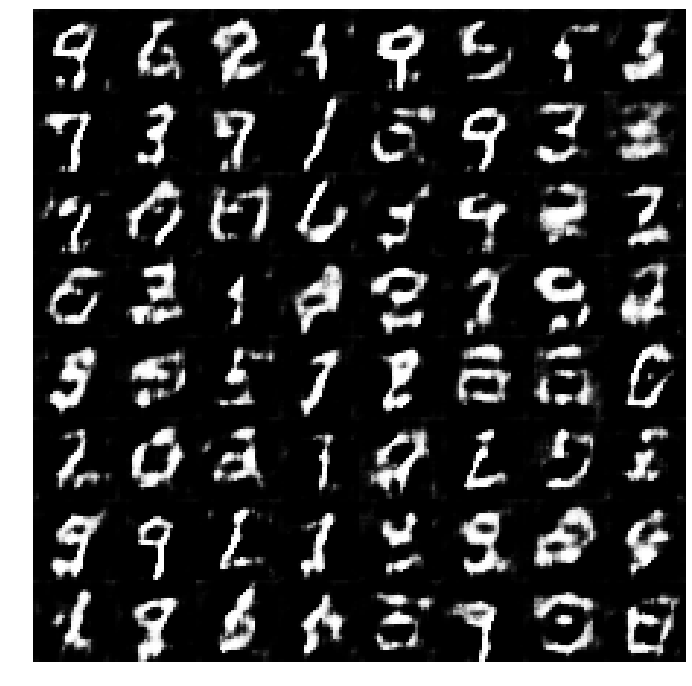

[Epoch 25/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


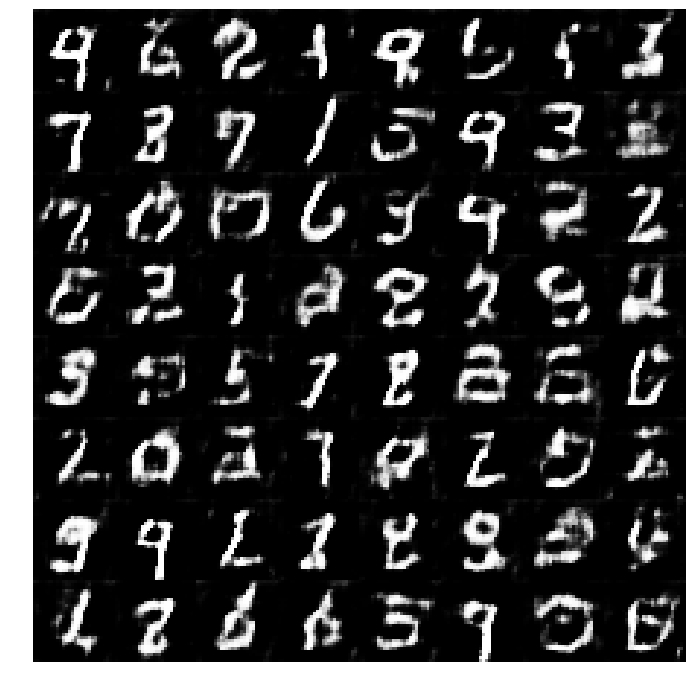

[Epoch 30/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


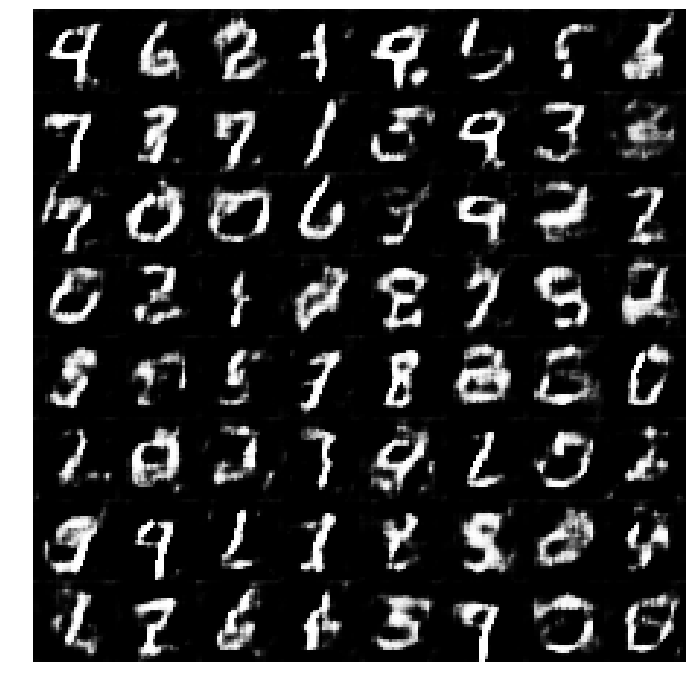

[Epoch 35/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


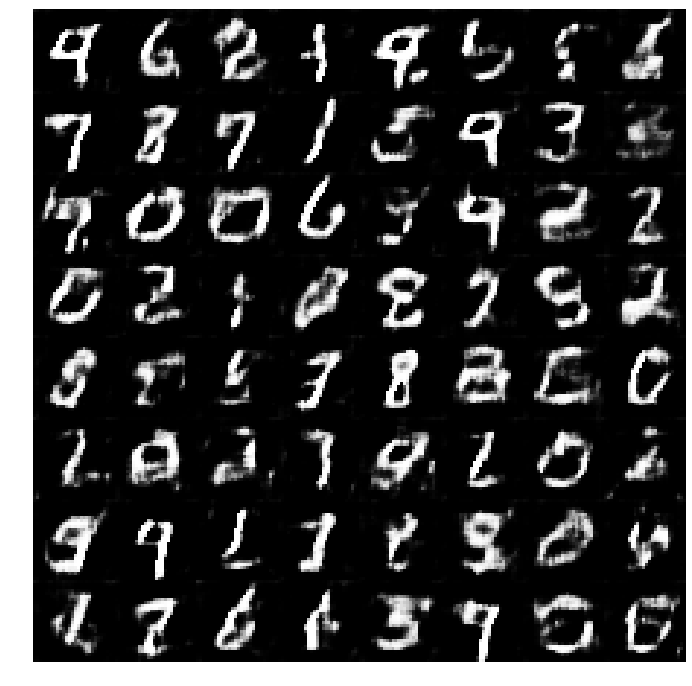

[Epoch 40/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


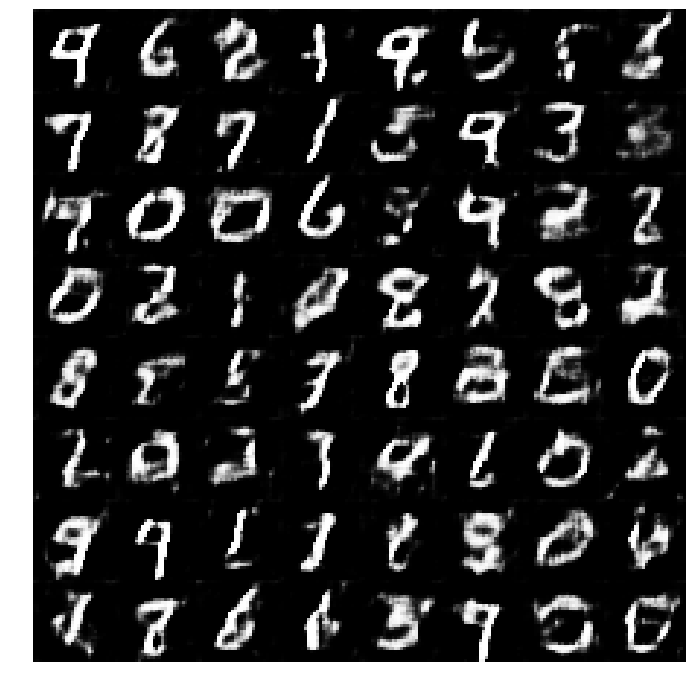

[Epoch 45/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


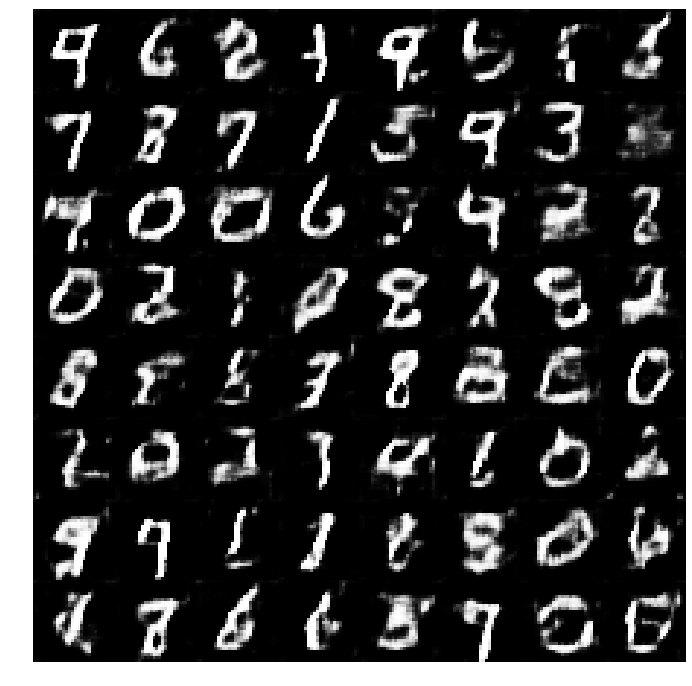

[Epoch 50/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


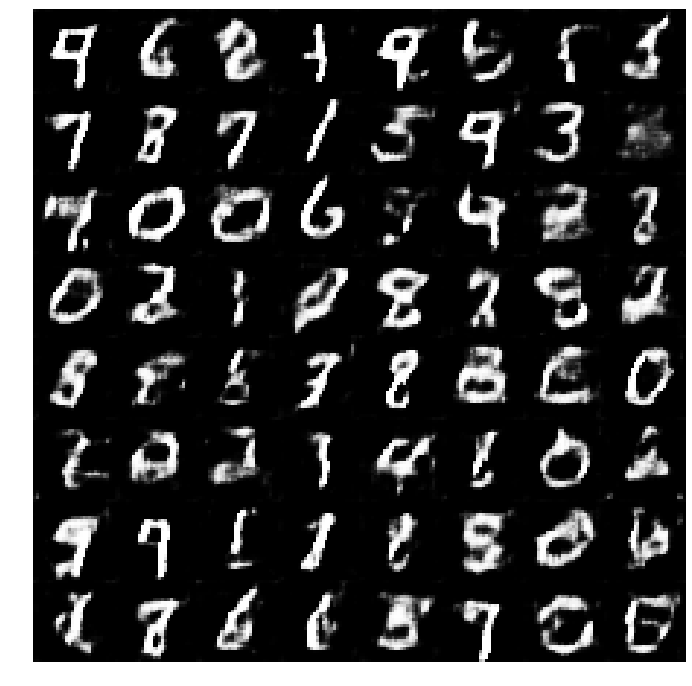

[Epoch 55/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


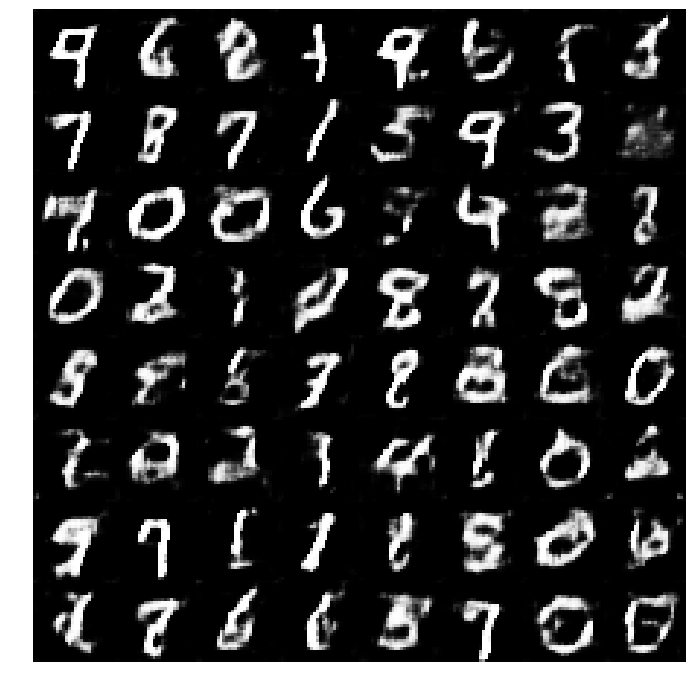

[Epoch 60/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


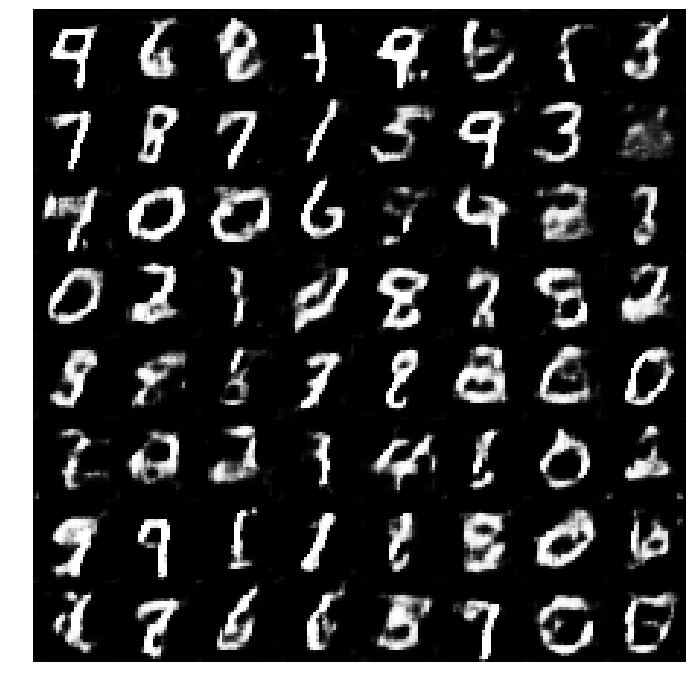

[Epoch 65/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


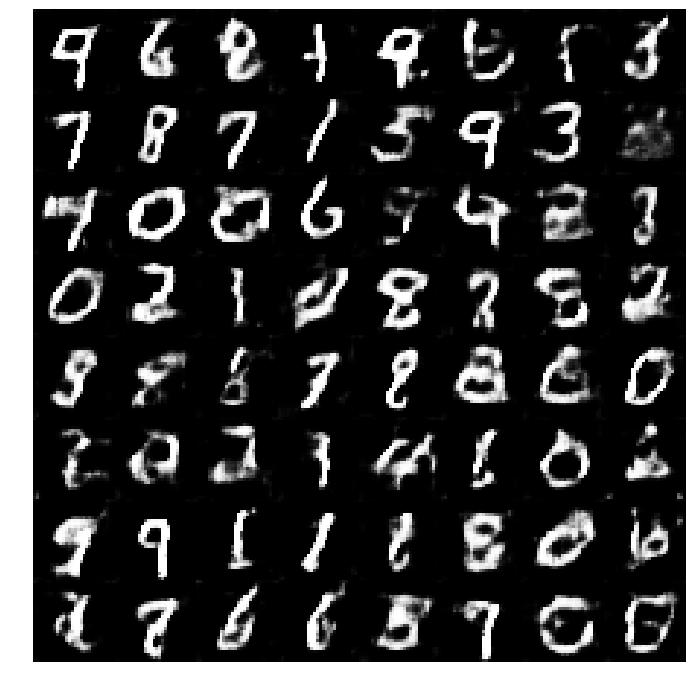

[Epoch 70/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


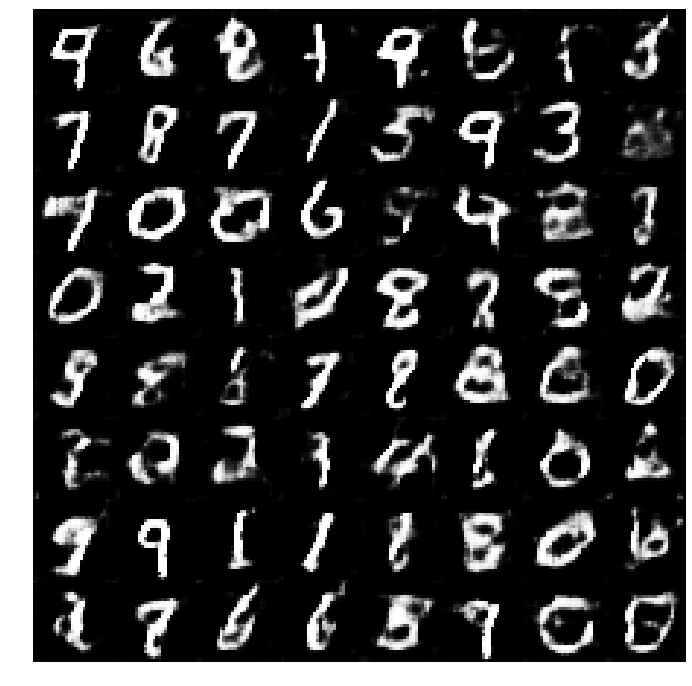

[Epoch 75/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


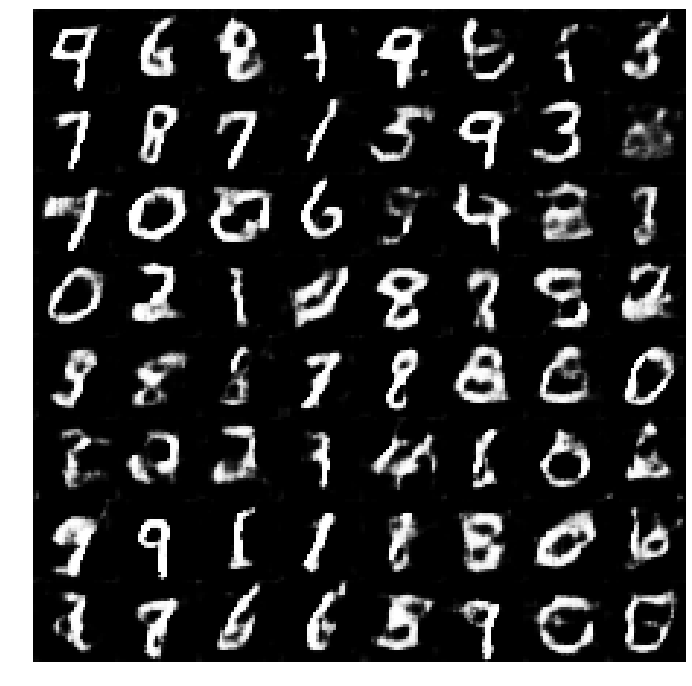

[Epoch 80/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


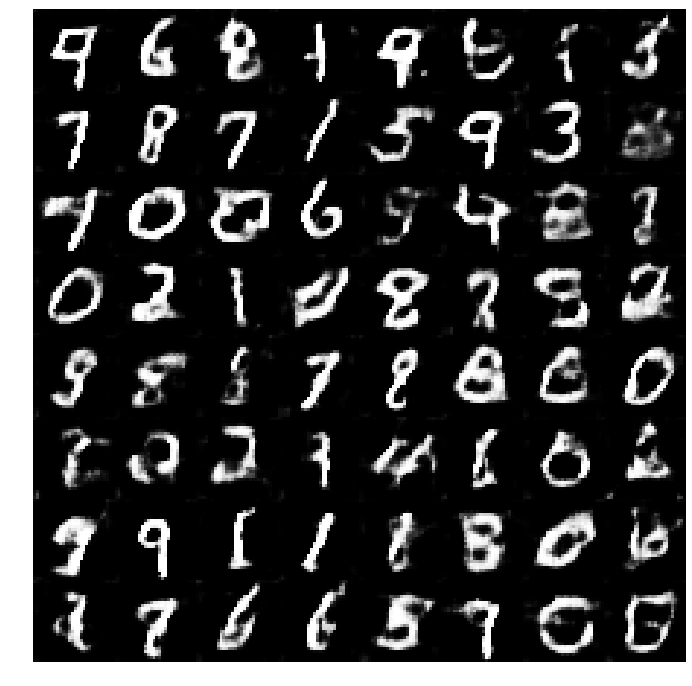

[Epoch 85/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


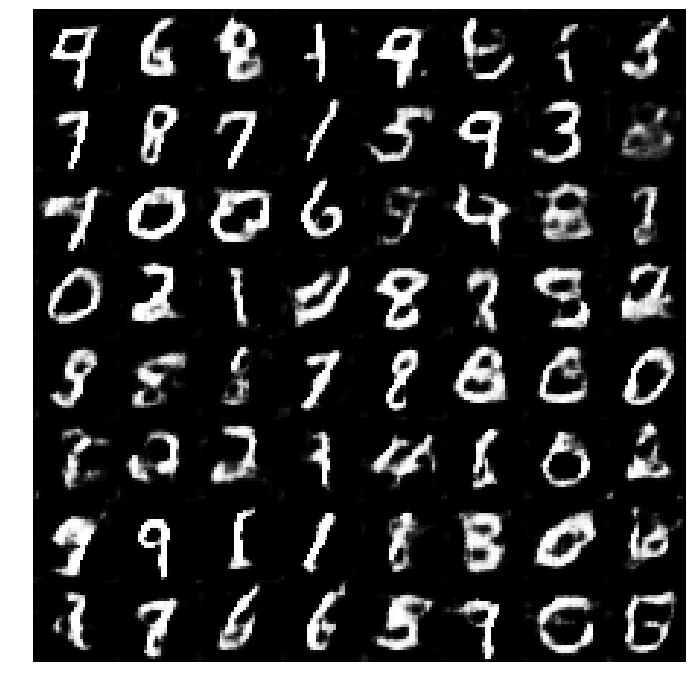

[Epoch 90/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


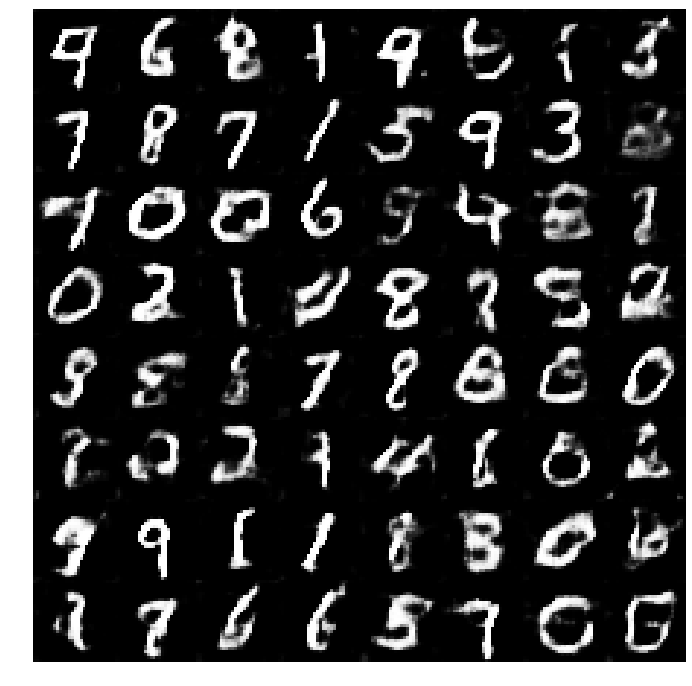

[Epoch 95/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


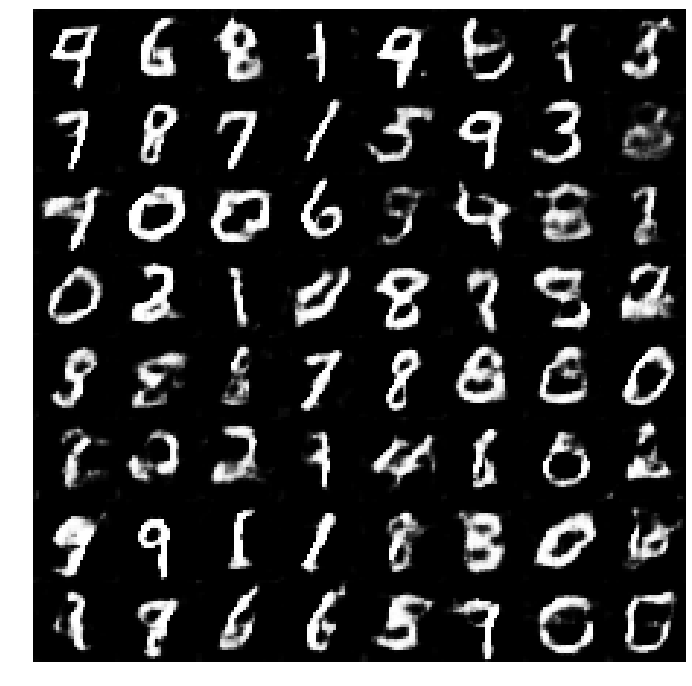

[Epoch 100/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


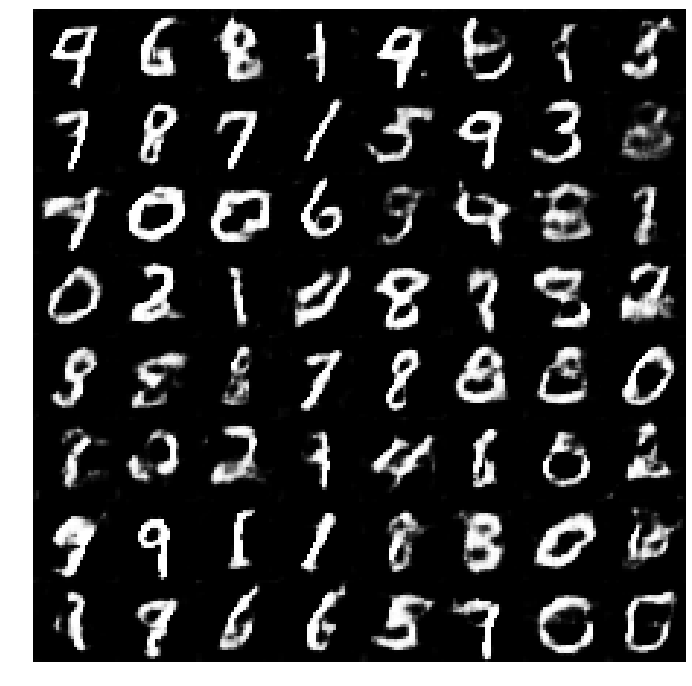

[Epoch 105/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


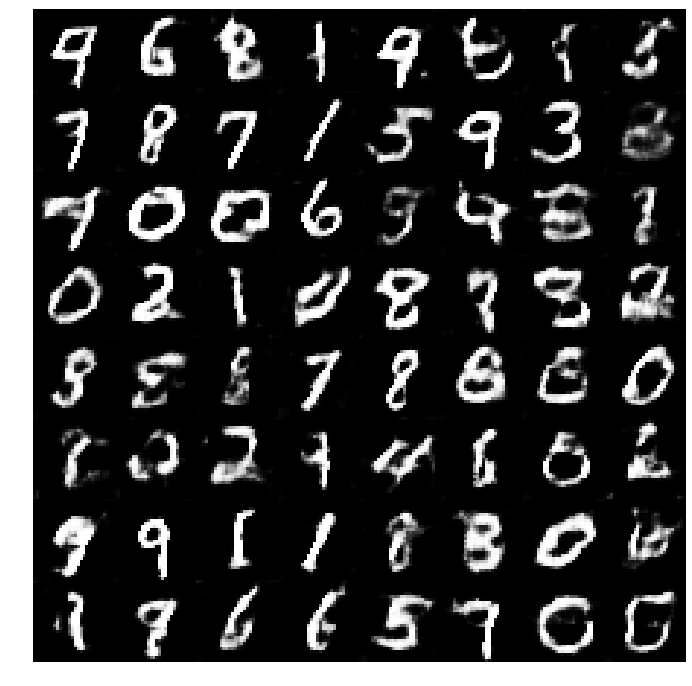

[Epoch 110/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


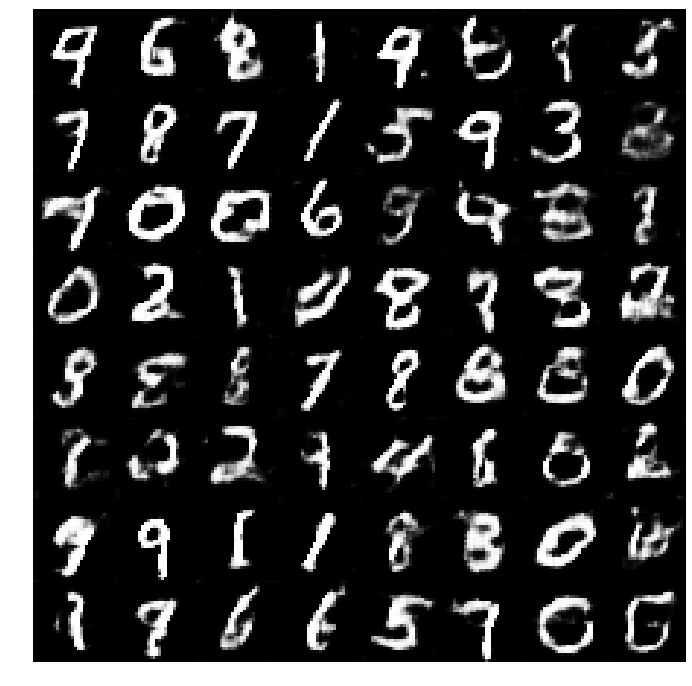

[Epoch 115/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


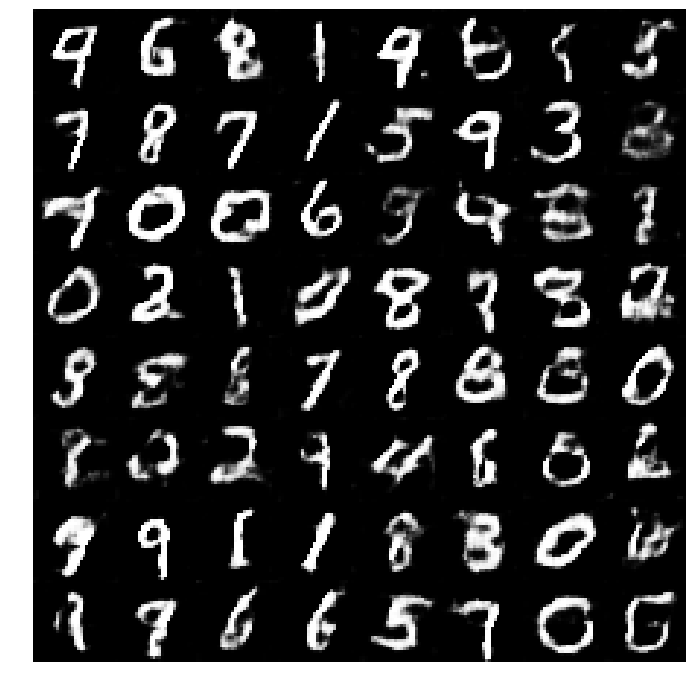

[Epoch 120/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


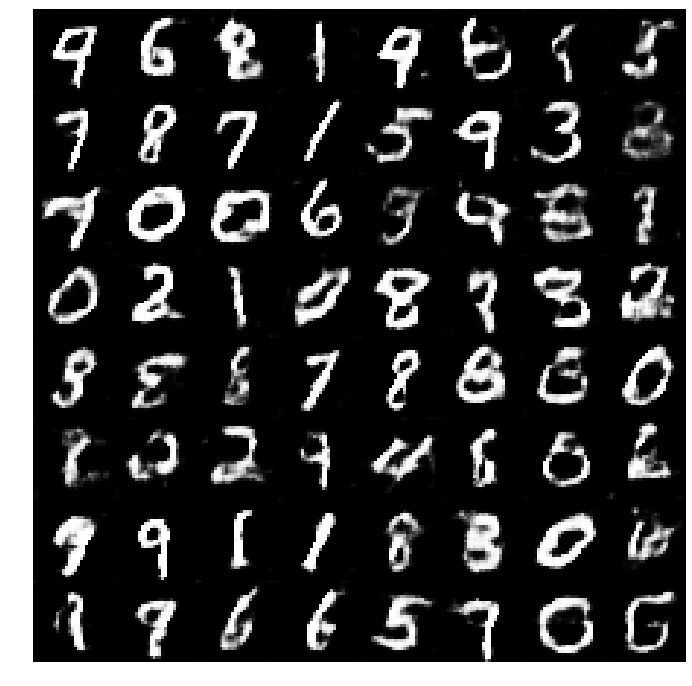

[Epoch 125/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


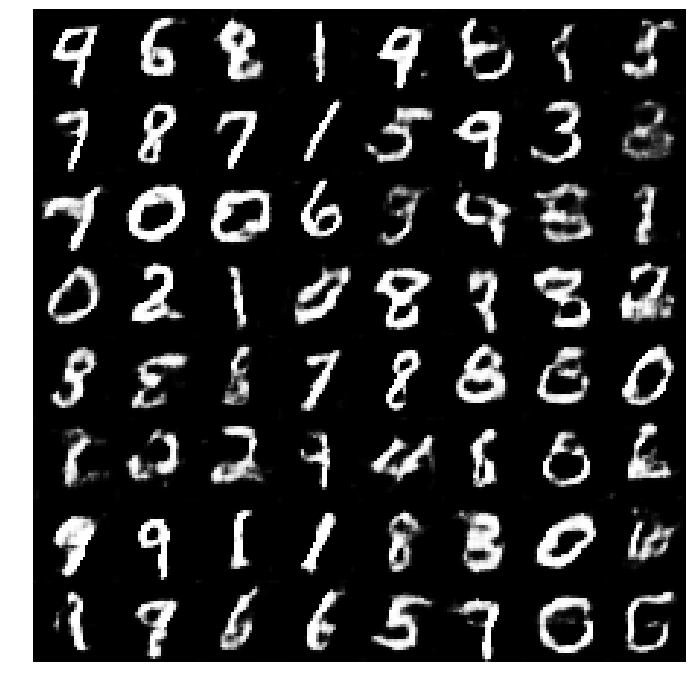

[Epoch 130/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


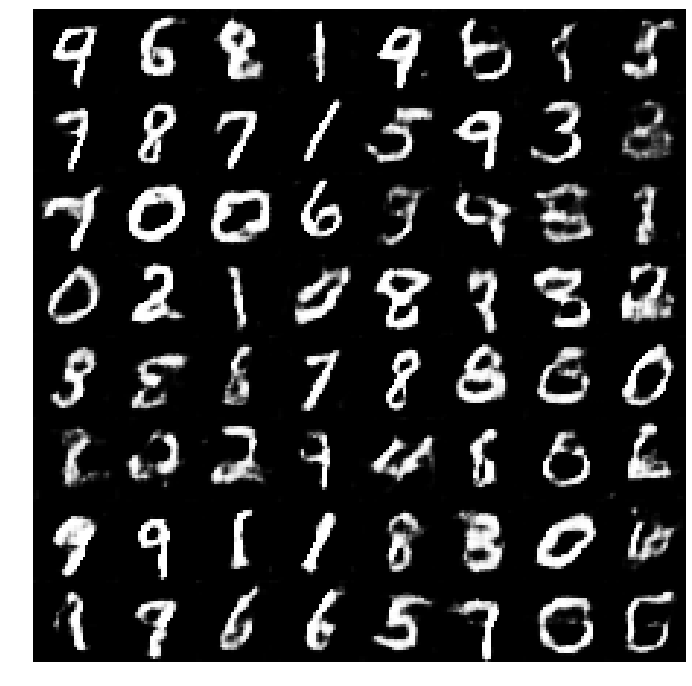

[Epoch 135/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


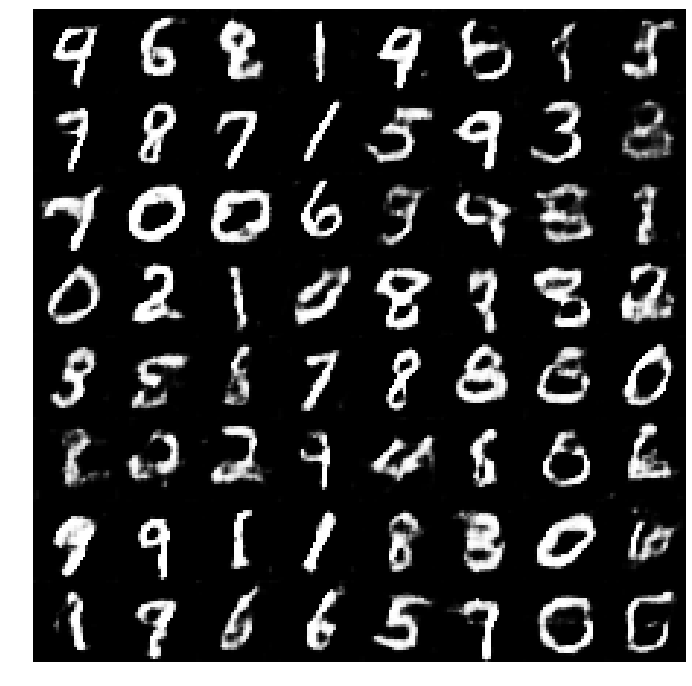

[Epoch 140/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


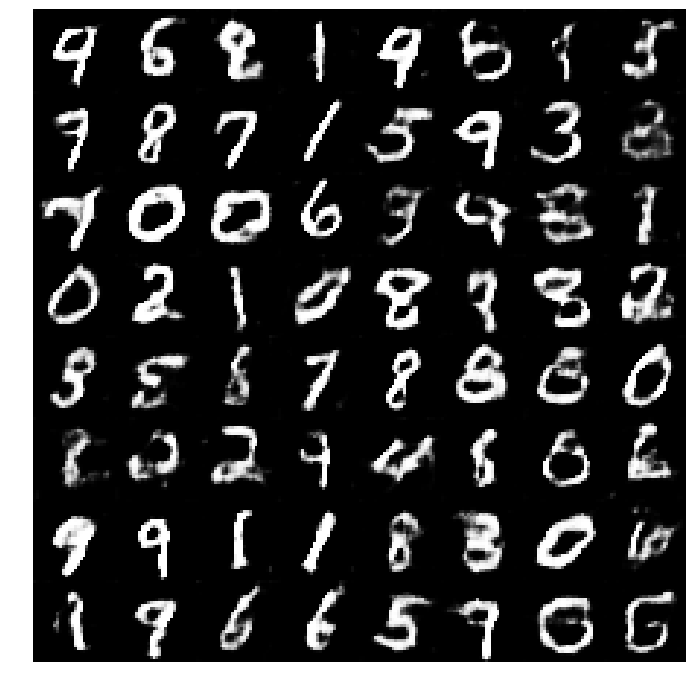

[Epoch 145/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


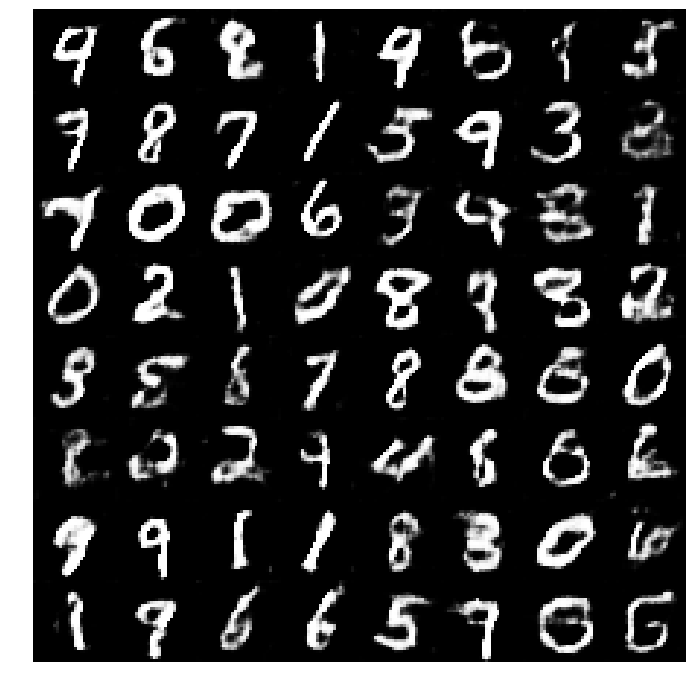

[Epoch 150/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


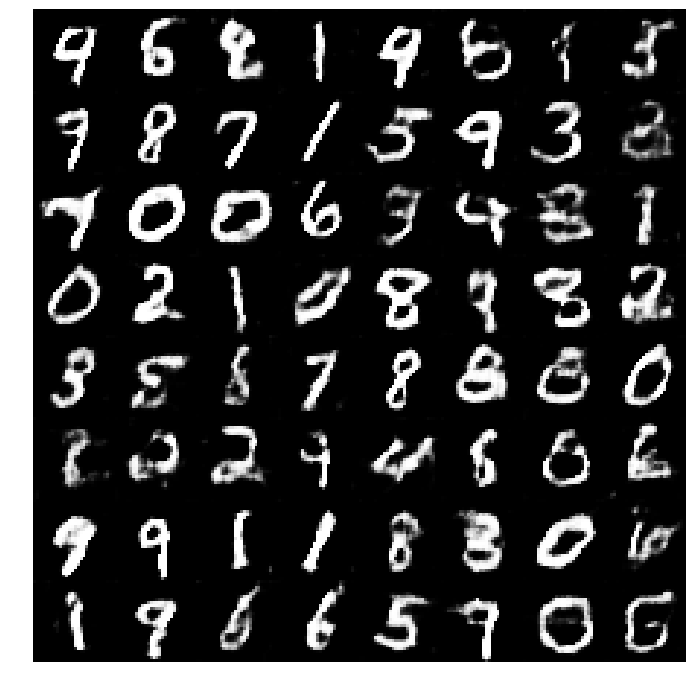

[Epoch 155/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


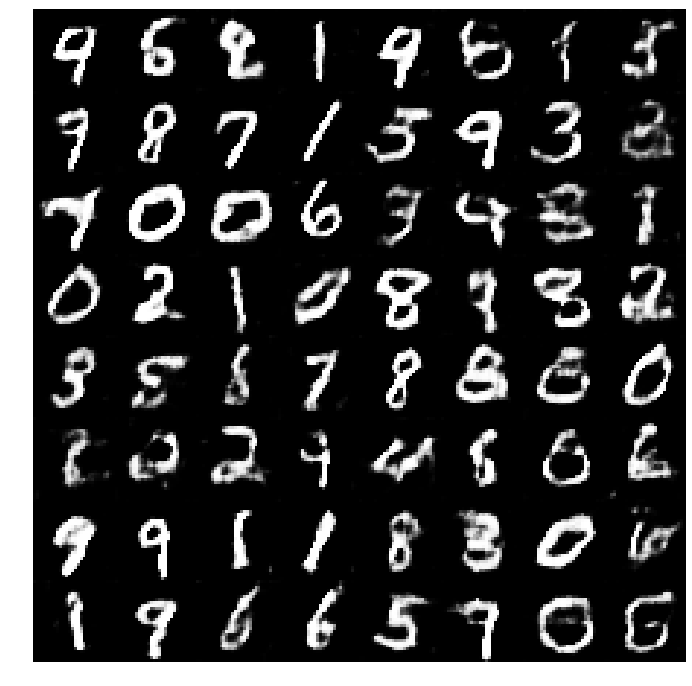

[Epoch 160/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


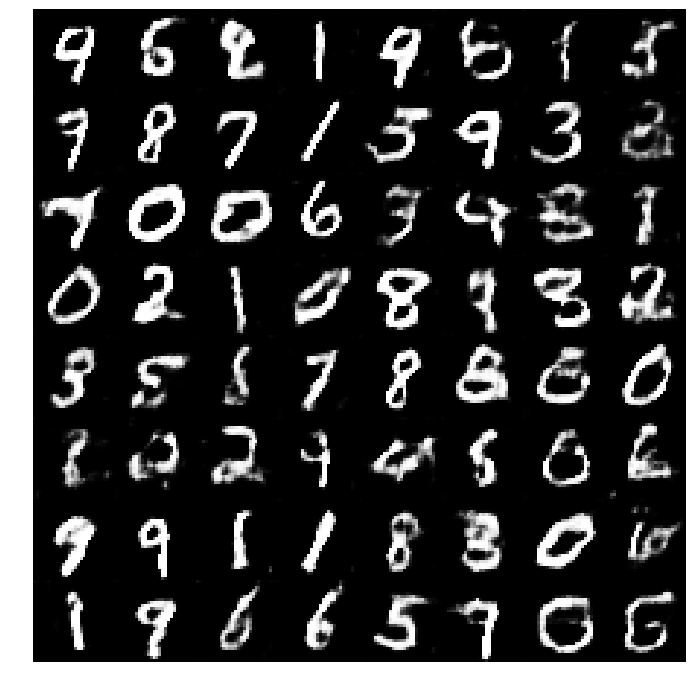

[Epoch 165/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


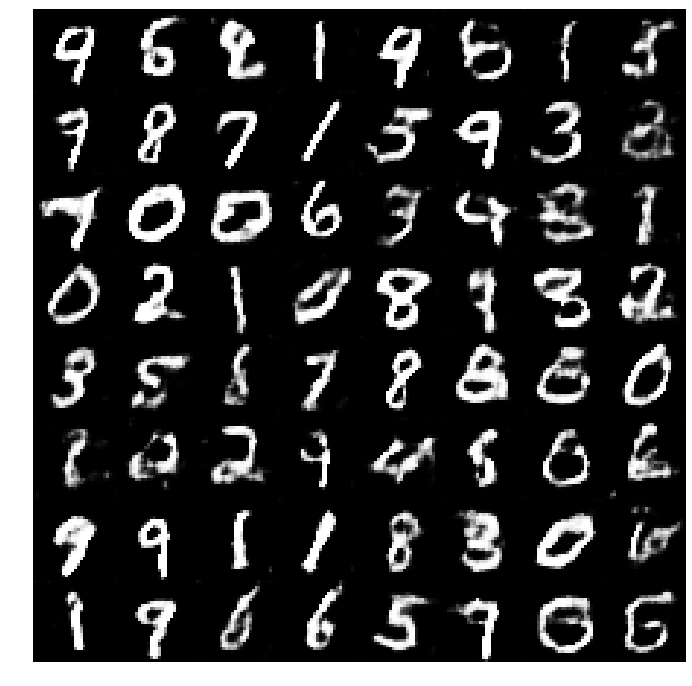

[Epoch 170/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


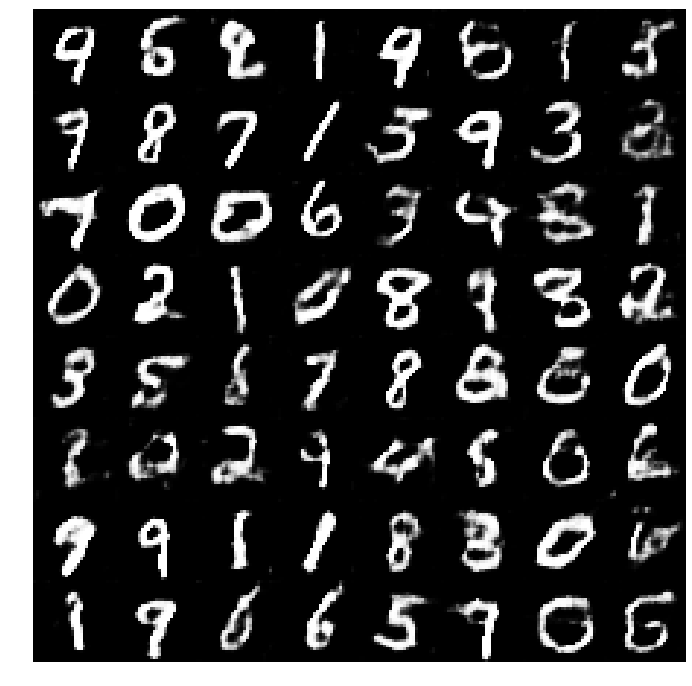

[Epoch 175/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


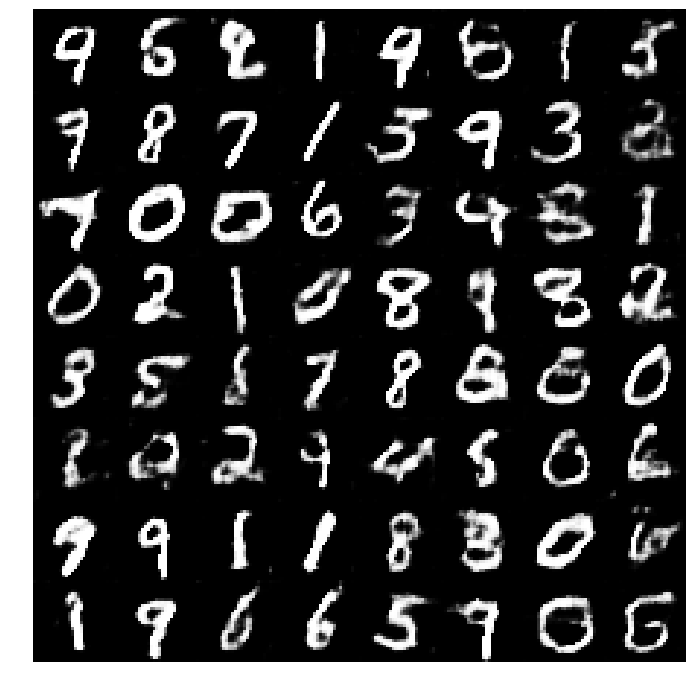

[Epoch 180/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


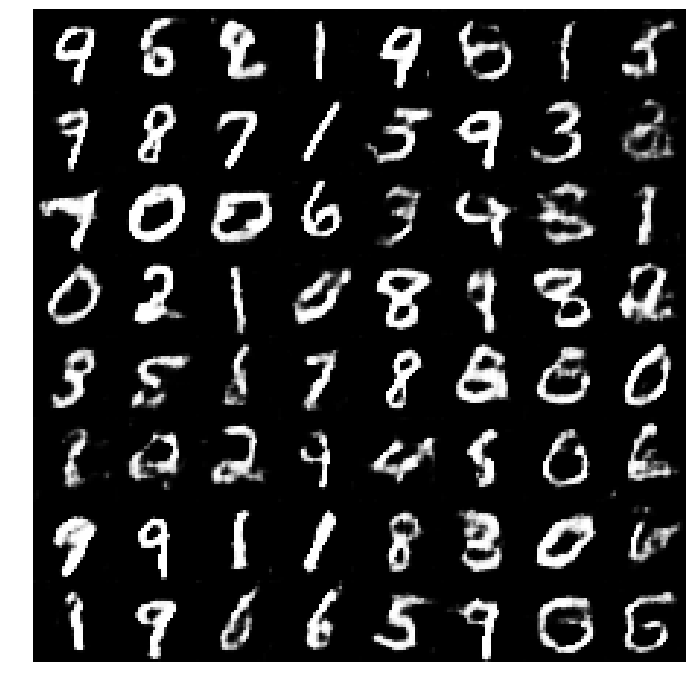

[Epoch 185/100000] -- Saved ./checkpoints/d_lr_2e-05_g_lr2e-05_0.5_1_100000_dbn_True_gbn_True_128_4_2_Mar-23-2019-17h40m21s


KeyboardInterrupt: 

In [8]:
with tf.Graph().as_default() as graph:
    z = tf.placeholder(tf.float32, shape=[None, Z_DIM])
    z_fixed = tf.placeholder(tf.float32, shape=[None, Z_DIM])
    x = tf.placeholder(tf.float32, shape=[None, HEIGHT, WIDTH, CHANNELS])
    
    
    g = generator(z, g_filters, g_kernels, g_strides, 
                  training=True, reuse=False, use_batchnorm=G_USE_BATCHNORM)
    
    g_fixed = generator(z_fixed, g_filters, g_kernels, g_strides, 
                        training=True, reuse=True,  use_batchnorm=G_USE_BATCHNORM)
    
    real_logits = discriminator(x, d_filters, d_kernels, d_strides, 
                                training=True, reuse=False, use_batchnorm=D_USE_BATCHNORM)
    
    fake_logits = discriminator(g, d_filters, d_kernels, d_strides, 
                                training=True, reuse=True, use_batchnorm=D_USE_BATCHNORM)
    
    w_distance = tf.reduce_mean(real_logits) - tf.reduce_mean(fake_logits)
    d_loss = -w_distance
    g_loss = -tf.reduce_mean(fake_logits)
    
    w_distance_summary = tf.summary.scalar("w_distance", w_distance)
    d_loss_summary = tf.summary.scalar("d_loss", d_loss)
    g_loss_summary = tf.summary.scalar("g_loss", g_loss)

    images_summary_fixed = tf.summary.image("generated_images_fixed", (g_fixed + 1.) / 2.)
    images_summary = tf.summary.image("generated_images", (g + 1.) / 2.)

    trainable_vars = tf.trainable_variables()
    
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if 'discriminator' in var.name]
    g_vars = [var for var in trainable_vars if 'generator' in var.name]
    
    # Loss: Wasserstein loss. REquires clipping WEIGHTS to ensure LIPSCHITZ CONSTRAINTS
    d_clip = [p.assign(tf.clip_by_value(p, -WEIGHT_CLIP, WEIGHT_CLIP)) for p in d_vars]

    d_optim = tf.train.RMSPropOptimizer(D_LEARNING_RATE)\
                    .minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.RMSPropOptimizer(G_LEARNING_RATE)\
                    .minimize(g_loss, var_list=g_vars)
    
        
    d_summary = tf.summary.merge([d_loss_summary, w_distance_summary])
    g_summary = tf.summary.merge([g_loss_summary, images_summary_fixed, images_summary])
    
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter("./runs/{}".format(RUN_NAME), sess.graph)
    summary_step = 0
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    z_fixed_input = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM])

    # Note: Epochs here are a bit different. We're going to randomly sample the training set;
    # 5 iters on D and 1 iter on G will constitute an epoch.
    i = 0
    epoch = 0
    while epoch < N_EPOCHS:
        for _ in range(D_ITERS):
            if i >= len(image_list) - BATCH_SIZE:
                writer.add_summary(g_summary_result, summary_step)
                writer.add_summary(d_summary_result, summary_step)
                summary_step += 1

                if (epoch % 5 == 0):
                    plot_images(inverse_transform(g_img))
                    save_path = saver.save(sess, "./checkpoints/{}".format(RUN_NAME))
                    print(f"[Epoch {epoch}/{N_EPOCHS}] -- Saved {save_path}")

                i = 0
                epoch += 1
                np.random.shuffle(image_list)
                
            
            choices = image_list[i:i + BATCH_SIZE]
            i += BATCH_SIZE
            
            z_input = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM])
            x_input = np.zeros([BATCH_SIZE, HEIGHT, WIDTH, CHANNELS])
            for k in range(0, BATCH_SIZE):
                x_input[k] = cv2.imread(os.path.join(image_dir, choices[k]))[:,:,[0]]
            
            x_input = transform(x_input / 255)
            sess.run(d_clip)
            [_, d_summary_result, d_loss_val] = sess.run([d_optim, d_summary, d_loss], 
                                                         feed_dict={z: z_input, x: x_input})
            
        for _ in range(G_ITERS):
            z_input = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM])
            sess.run(d_clip)
            [_, g_img, g_summary_result] = sess.run([g_optim, g_fixed, g_summary], 
                                                    feed_dict={z: z_input,
                                                               z_fixed: z_fixed_input}) 
        
                
      

In [ ]:
x_input.min()

In [ ]:
g_img.max()

In [ ]:
g_img.min()

In [ ]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, './checkpoints/d_lr_1e-05_g_lr1e-05_0.5_1_100000_dbn_True_gbn_True_256_5_1_Mar-18-2019-23h17m25s')
    d_vars = [var for var in tf.trainable_variables() if 'discriminator' in var.name]
    d_vars_eval = sess.run(d_vars)

In [ ]:
for dvar in d_vars_eval:
    print(dvar.max())

In [ ]:
conv_out_size_same(7, 2)

In [ ]:
for dvar in d_vars_eval:
    print(dvar.min())